### Transfer Learning VGG16 unfreeze des 8 dernières couches
> Reprise du modèle entrainé sur la classification

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import gradcam

In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [4]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


In [5]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

###### Récupération du modèle entrainé sur la classification

In [6]:
from keras.models import load_model
# load model
model = load_model('vgg16')

In [7]:
for layer in model.layers: 
    print(layer.name, layer.trainable)

vgg16 True
global_average_pooling2d_1 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True


In [8]:
base_model = model.layers[0]

#### Freeze les couches de VGG16  sauf les 8 dernièrespour affiner les poids du modèle
> learning rate à 1e-4 pour ne pas trop dérégler les poids pré-entrainés

In [9]:
# Freeze les couches VGG19, sauf les 8 dernières
for layer in base_model.layers[:-8]: 
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 6161s 18s/step - loss: 0.6107 - accuracy: 0.8039 - val_loss: 0.3003 - val_accuracy: 0.8969
Epoch 2/16
342/342 [==============================] - 6059s 18s/step - loss: 0.1362 - accuracy: 0.9572 - val_loss: 0.0878 - val_accuracy: 0.9711
Epoch 3/16
342/342 [==============================] - 6068s 18s/step - loss: 0.0794 - accuracy: 0.9743 - val_loss: 0.0706 - val_accuracy: 0.9740
Epoch 4/16
342/342 [==============================] - 6138s 18s/step - loss: 0.0951 - accuracy: 0.9691 - val_loss: 0.1042 - val_accuracy: 0.9704
Epoch 5/16
342/342 [==============================] - 6018s 18s/step - loss: 0.0643 - accuracy: 0.9788 - val_loss: 0.1025 - val_accuracy: 0.9667


In [11]:
model.save('vgg16_8')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16_8\assets


#### Prédictions sur données évaluations

In [12]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [13]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 886s 8s/step - loss: 0.0922 - accuracy: 0.9734


[0.09222392737865448, 0.9733840227127075]

In [14]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.96      1.00      0.98       222
  eosinophil       1.00      1.00      1.00       627
erythroblast       0.89      0.99      0.94       311
          ig       0.96      0.95      0.95       590
  lymphocyte       0.96      0.95      0.96       236
    monocyte       0.99      0.92      0.95       302
  neutrophil       0.99      0.97      0.98       682
    platelet       1.00      1.00      1.00       449

    accuracy                           0.97      3419
   macro avg       0.97      0.97      0.97      3419
weighted avg       0.97      0.97      0.97      3419



### GRAD CAM

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 15,898,184
Trainable params: 14,162,696
Non-trainable params: 1,735,488
__________________________________

In [17]:
# Reconstruit le modèle car problème de base_model avec GradCam
x = base_model.output
x = model.get_layer('global_average_pooling2d_1')(x)
x = model.get_layer('dense_4')(x)
x = model.get_layer('dense_5')(x)
x = model.get_layer('dense_6')(x)
x = model.get_layer('dense_7')(x)

In [21]:
model = Model(inputs = base_model.input, outputs = x)

In [22]:
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

##### Basophil

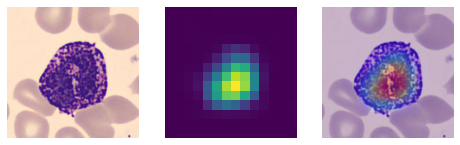

In [23]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BA_200697.jpg', img_size, model, last_conv_layer_name)

##### Eosinophil

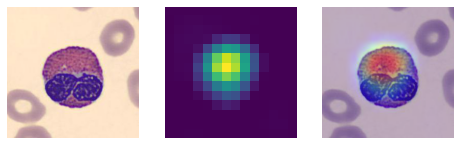

In [24]:
gradcam.display_headmap(preprocess_input, src_img + 'N_EO_40758.jpg', img_size, model, last_conv_layer_name)

##### Erythroblast

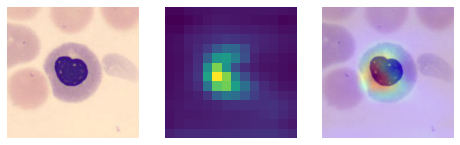

In [25]:
gradcam.display_headmap(preprocess_input, src_img + 'N_ERB_80122.jpg', img_size, model, last_conv_layer_name)

##### IG

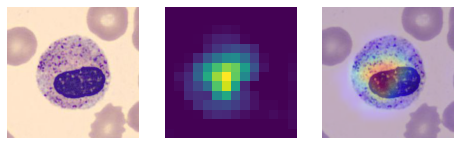

In [26]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MMY_19855.jpg', img_size, model, last_conv_layer_name)

##### Lymphocyte

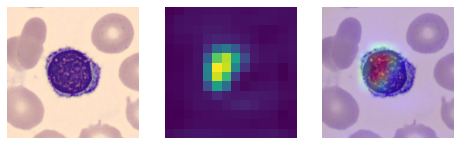

In [27]:
gradcam.display_headmap(preprocess_input, src_img + 'N_LY_99706.jpg', img_size, model, last_conv_layer_name)

##### Monocyte

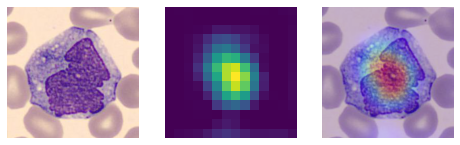

In [28]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MO_60562.jpg', img_size, model, last_conv_layer_name)

##### Neturophil

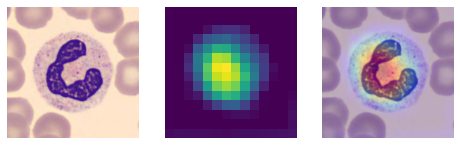

In [29]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BNE_53394.jpg', img_size, model, last_conv_layer_name)

##### Platelet

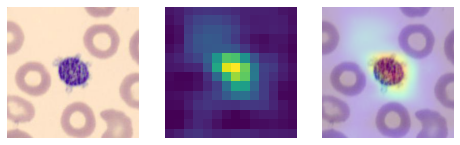

In [30]:
gradcam.display_headmap(preprocess_input, src_img + 'N_PLATELET_4736.jpg', img_size, model, last_conv_layer_name)